In [14]:
# Download and extract model
# ! wget http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/models/pytorch/resnet50_128_pytorch.tar.gz
# ! mkdir model
# ! tar -xvzf resnet50_128_pytorch.tar.gz -C model

In [9]:
# We will need this
# ! pip3 install gdown
# ! pip3 install shutil
# ! pip3 install tqdm
# ! sudo apt install unzip

In [16]:
# Download names
# ! mkdir data
# ! gdown https://drive.google.com/uc?id=1zRtJzbwomoRVQg5oFr621zpI0-4MnIFk
# ! mv names.tsv ./data/

In [15]:
# Download data
# ! gdown https://drive.google.com/uc?id=1jvjeTj8bJDpHvq6pJYlfxGnlLEKAHAxO
# ! mkdir data/test
# ! unzip test.zip -d data/test

In [2]:
import PIL
import torch
import glob as gb
import numpy as np
from PIL import Image
import pandas as pd
import os
import pylab as plt
import model.resnet50_128 as model

from sklearn.model_selection import train_test_split


from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import shutil

In [3]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

In [4]:
from pytorch_feature_extractor import initialize_model, image_encoding

CUDA is available!  Training on GPU ...


In [5]:
base_folder = '/home/care1e55/study/MIPT/cv/data/'
folder1 = base_folder + 'folder1/'
folder2 = base_folder + 'folder2/'
test_folder = base_folder + 'test_data/test_data/'
names_file = base_folder + 'class_mapping.csv'

# !mkdir '/home/care1e55/study/MIPT/cv/data/folder1/' & mkdir '/home/care1e55/study/MIPT/cv/data/folder2/'

In [6]:
names_file

'/home/care1e55/study/MIPT/cv/data/class_mapping.csv'

In [7]:
# names_file = '/home/care1e55/study/MIPT/cv/data/class_mapping.csv'
names = pd.read_csv(names_file, delimiter=',', names=['image', 'class'], skiprows=1)
names['image'] = names['image'].apply(str).apply(lambda x: test_folder+f'{x}')

In [74]:
names.head()

,image,class
0,/home/care1e55/study/MIPT/cv/data/test_data/te...,0
1,/home/care1e55/study/MIPT/cv/data/test_data/te...,1
2,/home/care1e55/study/MIPT/cv/data/test_data/te...,2
3,/home/care1e55/study/MIPT/cv/data/test_data/te...,3
4,/home/care1e55/study/MIPT/cv/data/test_data/te...,4


In [9]:
# prepare datasets for testing
sample = []
for i in range(500):
    row = names[names['class'] == i].iloc[0]
    sample.append((row['class'], row['image']))

# move 1 image from each class for prediction
for i in sample:
    shutil.copy(i[1], folder1+i[1].split('/')[-1])


In [10]:
images1 = gb.glob(folder1 + '*.jpg')
images2 = gb.glob(folder2 + '*.jpg')

In [11]:
print(folder1)
print(folder2)
print(len(images1))
print(len(images2))

/home/care1e55/study/MIPT/cv/data/folder1/
/home/care1e55/study/MIPT/cv/data/folder2/
500
115


In [12]:
images1[0]

'/home/care1e55/study/MIPT/cv/data/folder1/152189.jpg'

In [13]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
mtcnn = MTCNN(
    image_size=224, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

Running on device: cuda:0


In [15]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [49]:
workers = 4
batch_size = 4

def collate_fn(x):
    return x[0]

folder1_dataset = ImageFolderWithPaths('/home/care1e55/study/MIPT/cv/data/folder1_images/')
folder1_dataset.idx_to_class = {i:c for c, i in folder1_dataset.class_to_idx.items()}
folder1_loader = DataLoader(folder1_dataset, collate_fn=collate_fn, num_workers=workers)

In [50]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

In [81]:
folder1_aligned = []
folder1_paths = []
for x, y, p in tqdm(folder1_loader):
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        folder1_aligned.append(x_aligned)
        folder1_paths.append(p)

100%|██████████| 500/500 [00:11<00:00, 44.86it/s]


In [58]:
batch_size = 4
imgchunks = list(chunks(folder1_aligned, batch_size))
mapping_embeddings = []
for i, imgs in tqdm(enumerate(imgchunks), total=len(imgchunks)):
    stacked = torch.stack(imgs).to(device)
    mapping_embeddings += resnet(stacked).detach().cuda()
mapping_embeddings = torch.stack(mapping_embeddings).to(device)

100%|██████████| 125/125 [00:04<00:00, 31.12it/s]


In [60]:
batch_size = 4

def collate_fn(x):
    return x

test_dataset = ImageFolderWithPaths('/home/care1e55/study/MIPT/cv/data/test_data/')
test_dataset.idx_to_class = {i:c for c, i in test_dataset.class_to_idx.items()}
test_loader = DataLoader(test_dataset, collate_fn=collate_fn, num_workers=workers, batch_size=batch_size)

In [66]:
for i in test_loader:
    batch = i
    break

In [68]:
# batch

In [70]:
test_aligned = []
test_paths = []
# for batch in tqdm(test_loader)
for x, y, p in batch:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        test_aligned.append(x_aligned)
        test_paths.append(p)

batch_embeddings = []
batch_size = 4
imgchunks = list(chunks(test_aligned, batch_size))
for i, imgs in tqdm(enumerate(imgchunks), total=len(imgchunks)):
    stacked = torch.stack(imgs).to(device)
    batch_embeddings += resnet(stacked).detach().cuda()
batch_embeddings = torch.stack(batch_embeddings).to(device)

100%|██████████| 1/1 [00:00<00:00, 48.81it/s]


In [71]:
pred_idxs = torch.argmin(torch.cdist(batch_embeddings.detach(), mapping_embeddings.detach(), p=2.0), 1)

In [72]:
pred_idxs

tensor([107, 148, 146, 232], device='cuda:0')

In [82]:
list(map(folder1_paths.__getitem__, pred_idxs))

['/home/care1e55/study/MIPT/cv/data/folder1_images/sub/039324.jpg',
 '/home/care1e55/study/MIPT/cv/data/folder1_images/sub/052329.jpg',
 '/home/care1e55/study/MIPT/cv/data/folder1_images/sub/050760.jpg',
 '/home/care1e55/study/MIPT/cv/data/folder1_images/sub/080997.jpg']

In [79]:
folder1_paths

[]

In [111]:
# from shutil import copyfile

In [ ]:
# import shutil

In [119]:
# base_dir = "/home/care1e55/study/MIPT/cv/data/mapping/"
# for i in names.iterrows():
#     img_name = os.path.split(i[1][0])[1]
#     print(img_name, i[1][0], i[1][1])
#     dest_dir = os.path.join(base_dir, str(i[1][1]))
#     dest_img = os.path.join(dest_dir, img_name)
#     print(dest_dir, dest_img)
#     os.makedirs(dest_dir, exist_ok=True)
#     shutil.copyfile(i[1][0], dest_img)
#     # break

e/care1e55/study/MIPT/cv/data/mapping/390/085922.jpg
053860.jpg /home/care1e55/study/MIPT/cv/data/test_data/test_data/053860.jpg 391
/home/care1e55/study/MIPT/cv/data/mapping/391 /home/care1e55/study/MIPT/cv/data/mapping/391/053860.jpg
024672.jpg /home/care1e55/study/MIPT/cv/data/test_data/test_data/024672.jpg 392
/home/care1e55/study/MIPT/cv/data/mapping/392 /home/care1e55/study/MIPT/cv/data/mapping/392/024672.jpg
109025.jpg /home/care1e55/study/MIPT/cv/data/test_data/test_data/109025.jpg 393
/home/care1e55/study/MIPT/cv/data/mapping/393 /home/care1e55/study/MIPT/cv/data/mapping/393/109025.jpg
043901.jpg /home/care1e55/study/MIPT/cv/data/test_data/test_data/043901.jpg 394
/home/care1e55/study/MIPT/cv/data/mapping/394 /home/care1e55/study/MIPT/cv/data/mapping/394/043901.jpg
125047.jpg /home/care1e55/study/MIPT/cv/data/test_data/test_data/125047.jpg 395
/home/care1e55/study/MIPT/cv/data/mapping/395 /home/care1e55/study/MIPT/cv/data/mapping/395/125047.jpg
009675.jpg /home/care1e55/study/

In [59]:
for i in folder1_loader:
    print(i)
    break

(<PIL.Image.Image image mode=RGB size=169x193 at 0x7FAD40ABC550>, 0, '/home/care1e55/study/MIPT/cv/data/folder1_images/sub/001625.jpg')


In [ ]:
test_dataset = ImageFolderWithPaths('/home/care1e55/study/MIPT/cv/data/test_data/')
test_dataset.idx_to_class = {i:c for c, i in test_dataset.class_to_idx.items()}
test_loader = DataLoader(test_dataset, collate_fn=collate_fn, num_workers=workers)

In [37]:
len(folder1_loader)

125

In [39]:
for i in folder1_loader:
    print(i)
    break

[(<PIL.Image.Image image mode=RGB size=169x193 at 0x7FAD4C3A4E48>, 0, '/home/care1e55/study/MIPT/cv/data/folder1_images/sub/001625.jpg'), (<PIL.Image.Image image mode=RGB size=196x218 at 0x7FAD4C3A4D30>, 0, '/home/care1e55/study/MIPT/cv/data/folder1_images/sub/001729.jpg'), (<PIL.Image.Image image mode=RGB size=166x190 at 0x7FAD4C3A45C0>, 0, '/home/care1e55/study/MIPT/cv/data/folder1_images/sub/001939.jpg'), (<PIL.Image.Image image mode=RGB size=292x310 at 0x7FAD4C3A4B38>, 0, '/home/care1e55/study/MIPT/cv/data/folder1_images/sub/002441.jpg')]


In [62]:
folder1_aligned = []
folder1_names = []
folder1_paths = []
for x, y, p in tqdm(folder1_loader):
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        # print('Face detected with probability: {:8f}'.format(prob))
        folder1_aligned.append(x_aligned)
        folder1_names.append(dataset.idx_to_class[y])
        folder1_paths.append(p)

  0%|          | 0/500 [00:00<?, ?it/s]


NameError: name 'dataset' is not defined

In [44]:
folder1_aligned = []
folder1_paths = []
for x, y, p in tqdm(folder1_loader):
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        # print('Face detected with probability: {:8f}'.format(prob))
        folder1_aligned.append(x_aligned)
        folder1_paths.append(p)

100%|██████████| 500/500 [00:10<00:00, 45.92it/s]


In [127]:
test_aligned = []
test_names = []
test_paths = []
for x, y, p in tqdm(test_loader):
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        # print('Face detected with probability: {:8f}'.format(prob))
        test_aligned.append(x_aligned)
        test_names.append(dataset.idx_to_class[y])
        test_paths.append(p)

  0%|          | 633/169396 [00:13<1:10:58, 39.63it/s]Process Process-41:
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f89b8715668>>
Traceback (most recent call last):
  File "/home/care1e55/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/care1e55/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 
  0%|          | 633/169396 [00:14<1:06:28, 42.31it/s]Traceback (mos

KeyboardInterrupt: 

In [103]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=127x159 at 0x7F89B898AF98>,
 0,
 '/home/care1e55/study/MIPT/cv/data/folder2_images/sub/168504.jpg')

In [46]:
batch_size = 4
imgchunks = list(chunks(folder1_aligned, batch_size))

In [47]:
embeddings = []
for i, imgs in tqdm(enumerate(imgchunks), total=len(imgchunks)):
    stacked = torch.stack(imgs).to(device)
    embeddings += resnet(stacked).detach().cuda()
embeddings = torch.stack(embeddings).to(device)

100%|██████████| 125/125 [00:04<00:00, 31.08it/s]


In [115]:
pred_idxs = torch.argmin(torch.cdist(embeddings.detach(), embeddings.detach(), p=2.0), 1)

In [121]:
# list(map(paths.__getitem__, pred_idxs))

In [90]:
def predict(folder1:str, folder2:str) -> list:
    images1 = gb.glob(folder1 + '*.jpg')
    images2 = gb.glob(folder2 + '*.jpg')
    model_eval = initialize_model()
    folder1_face_feats = image_encoding(model_eval, images1)
    folder2_face_feats = image_encoding(model_eval, images2)
    
    S = np.dot(folder2_face_feats, folder1_face_feats.T)

    return [(images2[i], images1[images.argmax()]) for i, images in enumerate(S)]

In [91]:
def predict_once(folder1:str, image2:str) -> str:
    images1 = gb.glob(folder1 + '*.jpg')
    images2 = gb.glob(image2)
    model_eval = initialize_model()
    folder1_face_feats = image_encoding(model_eval, images1)
    folder2_face_feats = image_encoding(model_eval, images2)

    S = np.dot(folder2_face_feats, folder1_face_feats.T)

    return images1[S.argmax()]

In [92]:
# small test
# (240, 224, 3)
# folder2 = '/home/care1e55/study/MIPT/cv/data/test_data/test_data/'
predictions = predict(folder1, folder2)

100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


In [14]:
# big test
predictions = predict(folder1, test_folder)

100%|██████████| 10556/10556 [1:25:35<00:00,  2.06it/s]


In [22]:
# import pickle
# with open('predictions.pickle', 'wb') as f:
#     pickle.dump(predictions, f)

In [71]:
prediction = predict_once(folder1, 'data/test/folder2/1.jpg')
prediction

100%|██████████| 1/1 [00:00<00:00, 53.37it/s]


'data/test/folder1/0.jpg'

In [60]:
# names = pd.read_csv(names_file, delimiter='\t', names=['class', 'image'])

In [122]:
names = pd.read_csv(names_file, delimiter=',', names=['image', 'class'], skiprows=1)
names['image'] = names['image'].apply(str).apply(lambda x: x.split('.')[0])

In [137]:
names

,image,class
0,107038,0
1,052329,1
2,050760,2
3,080997,3
4,113304,4
...,...,...
495,151916,495
496,160470,496
497,126103,497
498,006945,498


In [142]:
names[names['image'] == str(107038)]

,image,class
0,107038,0


In [102]:
# predictions

In [163]:
class FaceImagesClassDataset(Dataset):
    """
    Images Dataset only for printing
    """
    def __init__(self, predictions, names):
        super().__init__()

        self.predictions = predictions
        self.names = names

    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image
    
    def __len__(self):
         return len(predictions)
  
    def __getitem__(self, index):
        predicted = self._prepare_sample(self.load_sample(self.predictions[index][0]))
        source = self._prepare_sample(self.load_sample(self.predictions[index][1]))
        
        source_num = predictions[index][0].split('/')[-1].split('.')[-2]
        predicted_num = predictions[index][1].split('/')[-1].split('.')[-2]
        # print(source_num, predicted_num, names[names['image'] == str(predicted_num)])

        # source_class = names[names['image'] == str(source_num)]['class'].iloc[0]
        predicted_class = names[names['image'] == str(predicted_num)]['class'].iloc[0]
        # predicted_class, source_class = 0, 0
        # return predicted, source, predicted_class, source_class
        return predicted, source, predicted_class, predicted_class
    

In [164]:
face_images_class_dataset = FaceImagesClassDataset(predictions, names)

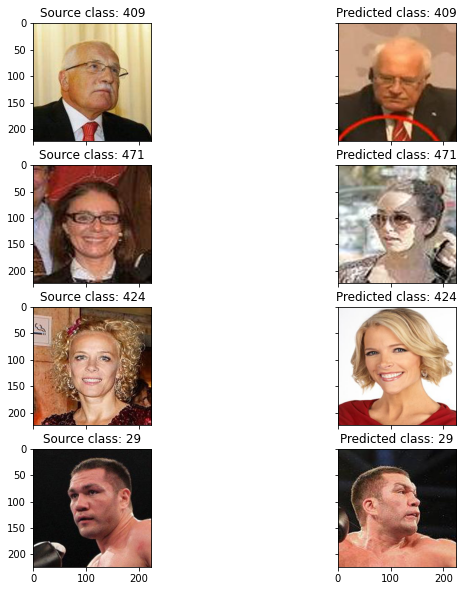

In [165]:
Ni = 4
RESCALE_SIZE = 224

fig, ax = plt.subplots(nrows=Ni, ncols=2,figsize=(10, 10), \
                        sharey=True, sharex=True)

for i in range(Ni):
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0, len(predictions)))
        source, predicted, source_class, predicted_class = face_images_class_dataset[random_characters]
        
        ax[i ,0].imshow(source)
        ax[i ,0].set_title('Source class: ' + str(source_class))
        ax[i ,1].imshow(predicted)
        ax[i ,1].set_title('Predicted class: ' + str(predicted_class))

In [189]:
class FaceClassDataset(Dataset):
    """
    Class Dataset only for accuracy score 
    """
    def __init__(self, predictions, names):
        super().__init__()

        self.predictions = predictions
        self.names = names

    
    def __len__(self):
         return len(predictions)
  
    def __getitem__(self, index):
        
        source_num = predictions[index][0].split('/')[-1].split('.')[-2]
        predicted_num = predictions[index][1].split('/')[-1].split('.')[-2]
        
        # source_class = names[names['image'] == int(source_num)]['class'].iloc[0]
        predicted_class = names[names['image'] == str(predicted_num)]['class'].iloc[0]
        
        return str(source_num)+'.jpg', predicted_class
    

In [190]:
face_class_dataset = FaceClassDataset(predictions, names)

In [204]:
final_preds = []
for i, face_pair in tqdm(
    enumerate(face_class_dataset), 
    total = len(face_class_dataset)
):
    final_preds.append(face_pair)
    print(face_pair)

100%|██████████| 115/115 [00:00<00:00, 1638.02it/s]('168594.jpg', 407)
('168598.jpg', 446)
('168509.jpg', 385)
('168568.jpg', 351)
('168577.jpg', 308)
('168618.jpg', 307)
('168515.jpg', 59)
('168529.jpg', 246)
('168557.jpg', 440)
('168578.jpg', 483)
('168561.jpg', 442)
('168571.jpg', 362)
('168531.jpg', 293)
('168589.jpg', 140)
('168543.jpg', 457)
('168534.jpg', 48)
('168525.jpg', 12)
('168564.jpg', 29)
('168613.jpg', 355)
('168519.jpg', 268)
('168516.jpg', 117)
('168562.jpg', 442)
('168617.jpg', 424)
('168558.jpg', 303)
('168583.jpg', 108)
('168572.jpg', 3)
('168565.jpg', 37)
('168604.jpg', 93)
('168511.jpg', 297)
('168538.jpg', 452)
('168600.jpg', 423)
('168545.jpg', 409)
('168549.jpg', 168)
('168615.jpg', 310)
('168518.jpg', 173)
('168552.jpg', 328)
('168539.jpg', 426)
('168505.jpg', 146)
('168512.jpg', 464)
('168523.jpg', 385)
('168566.jpg', 64)
('168542.jpg', 242)
('168582.jpg', 121)
('168546.jpg', 266)
('168541.jpg', 268)
('168590.jpg', 16)
('168544.jpg', 476)
('168528.jpg', 214)

In [205]:
final_preds[0]

('168594.jpg', 407)

In [206]:
pd.DataFrame(final_preds)

,0,1
0,168594.jpg,407
1,168598.jpg,446
2,168509.jpg,385
3,168568.jpg,351
4,168577.jpg,308
...,...,...
110,168599.jpg,280
111,168585.jpg,170
112,168526.jpg,264
113,168556.jpg,58


In [97]:
def face_accuracy(face_class_dataset):
    acum = 0
    for i, face_pair in tqdm(enumerate(face_class_dataset), 
                             total = len(face_class_dataset)):
        acum += int(face_pair[0] == face_pair[1])
    return acum/len(predictions)

face_accuracy(face_class_dataset)

  0%|          | 0/115 [00:00<?, ?it/s]


0.0